In [ ]:
# ------------------------------mount drive-------------------------------------
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/Colab\ Notebooks/nonlinear-sys-id/simple\ pendulum\ neurips/


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/nonlinear-sys-id/simple pendulum neurips


In [ ]:
import numpy as np
from scipy.stats import truncnorm
import random
import matplotlib.pyplot as plt
import math

g = 9.81  # (m/s^2)  gravity constant
dt = 0.01  # time_step for discrete-time system

def system_parameters():
    m = 0.1  # (kg)    mass
    l = 0.5  # (m) distance between the rotor and the center of mass
    k = 0.1  # controller gain
    return m, l, k

def generate_u(input_, time_hor, s_, mean, std, u_max, lb, ub):  # noise in control input
    if input_ == "trunc_guass":
        np.random.seed(s_)
        rv = truncnorm(-u_max, u_max, loc=mean, scale=std)
        r1 = rv.rvs(size=time_hor)
        return r1
    elif input_ == "uniform":
        np.random.seed(s_)
        r1 = np.random.uniform(low=lb, high=ub, size=time_hor)
        return r1
    elif input_ == "bernouli":
        np.random.seed(s_)
        r0 = np.random.rand(time_hor)
        r1 = []
        for k in range(len(r0)):
          if r0[k] < 0.5:
            r1.append(0.5)
          else:
            r1.append(-0.5)
        return r1

def generate_w(distr, time_hor, s_, mean, std, w_max, lb, ub):  # disturbance
    if distr == "trunc_guass":
        np.random.seed(s_)
        rv = truncnorm(-w_max, w_max, loc=mean, scale=std)
        r1 = rv.rvs(size=time_hor)
        rv = truncnorm(-w_max, w_max, loc=mean, scale=std)
        r2 = rv.rvs(size=time_hor)
        return r1, r2
    elif distr == "uniform":
        np.random.seed(s_)
        r1 = np.random.uniform(low=lb, high=ub, size=time_hor)
        r2 = np.random.uniform(low=lb, high=ub, size=time_hor)
        return r1, r2
    elif distr == "bernouli":
        np.random.seed(s_)
        r01 = np.random.rand(time_hor)
        r02 = np.random.rand(time_hor)
        r1 = []
        r2 = []
        for k in range(len(r01)):
          if r01[k] < 0.5:
            r1.append(100)
          else:
            r1.append(-100)
        for k in range(len(r02)):
          if r02[k] < 0.5:
            r2.append(100)
          else:
            r2.append(-100)
        return r1, r2

class SimplePendulumDynamics:
    def __init__(self, distr, input):
        self.state = None
        self.u0 = None
        self.distr = distr
        self.input = input
        self.m, self.l, self.k = system_parameters()
        self.alpha_list = []
        self.omega_list = []
        self.phi_s_u_list = []
        self.b_s_list = []
        self.phi_list = []
        self.state_list = []

    def plot_trajectory(self):
        t_list = np.array(range(len(self.alpha_list))) * dt
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
        plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.5, hspace=0.4)   # wspace: space between subplots in a row

        axs[0].plot(t_list, np.array(self.alpha_list), label='$\\alpha$')
        axs[0].set_xlabel('time (s)')
        axs[0].set_ylabel('$\\alpha$ ($rad$)')
        axs[0].legend()

        axs[1].plot(t_list, self.omega_list, label='$\omega$')
        axs[1].set_xlabel('time (s)')
        axs[1].set_ylabel('$\omega$ ($rad/s^{2}$)')
        axs[1].legend()

        plt.show()

    def update_feature_list(self, phi_s_u, s_, s, ex):
        self.phi_s_u_list.append(phi_s_u)
        self.b_s_list.append(s - s_ - ex)

    def update_feat(self, y):
        self.phi_list.append(y)


    def get_trajectory_3(self, x0, time_hor, s_u, s_w, param_u, mult_u, param_w, mult_w):

        # ----------------------------------------- initial states -----------------------------------------------------
        self.state = x0
        x = np.array(x0)
        alpha_ = x[0]  # angle
        omega_ = x[1]  # angular velocity

        #  ------------------------------------- Storing the states - ---------------------------------------------
        self.alpha_list = [alpha_]
        self.omega_list = [omega_]
        self.state_list = [np.array([alpha_, omega_])]

        if self.input == "trunc_guass":
          u_max_ = param_u[2]
        else:
          u_max_ = 1.0

        if self.distr == "trunc_guass":
          w_max_ = param_w[2]
        else:
          w_max_ = 1.0

        # -----------------  random noise and disturbance generation ---------------------------------------------------
        U1_list = generate_u(self.input, time_hor, s_u, mean=param_u[0], std=param_u[1], u_max=u_max_, lb=param_u[0], ub=param_u[1])
        W1_list, W2_list = generate_w(self.distr, time_hor, s_w, mean=param_w[0], std=param_w[1], w_max=w_max_, lb=param_w[0], ub=param_w[1])

        for t in range(time_hor):

            s_ = omega_

            # ------------------  noise in control input  (for exploration)  ----------------------------------------
            u1 = U1_list[t]

            # ----------------   noise in control input  (for exploration)  -----------------------------------------
            w1 = mult_w[0] * W1_list[t]
            w2 = mult_w[1] * W2_list[t]

            # ----------------------------------------  PD control + noise  ------------------------------------------
            u = - self.k * omega_ + u1

            # ------------------------------------------  Dynamic model ----------------------------------------------
            alpha_dot = omega_ + w1
            omega_dot = - g * math.sin(alpha_) / self.l + u / (self.m * self.l * self.l) + w2

            phi_s_u = np.array([-g*math.sin(alpha_), u])
            self.update_feat(phi_s_u)

            # -------------------------------------- Updating the states --------------------------------------------
            alpha = alpha_ + dt * alpha_dot
            omega = omega_ + dt * omega_dot

            self.state = np.array([alpha, omega])

            s = omega

            self.update_feature_list(dt * phi_s_u, s_, s, 0)

            omega_ = omega
            alpha_ = alpha

            # ------------------------------------- Storing the states ----------------------------------------------
            self.alpha_list.append(alpha)
            self.omega_list.append(omega)
            self.state_list.append(np.array([alpha, omega]))

In [ ]:
# --------------------------import packages-------------------------------------
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from scipy.stats import norm
np.set_printoptions(threshold=np.inf)

# ----------------------import classes and functions----------------------------
# from pendulum_dynamics import SimplePendulumDynamics

# --------------------------ground_truth parameters-----------------------------
m, l, _ = system_parameters()
ground_truth = [1 / l, 1 / m / l / l]
print("-----------------------------------------------------------------------")
print("ground truth = ", ground_truth)
print("-----------------------------------------------------------------------")

n_epoch = 10             # number trajectories
max_time_hor = 30002      # maximum trajectory length

# ------------------------------disturbacne-------------------------------------
# disturbance: str = "trunc_guass"
# parameter_dist = [0.0, 0.5, 2]  # mean and std

# disturbance: str = "bernouli"

disturbance: str = "uniform"
parameter_dist = [-1, 1]  # lb and ub

mult_w = [1, 1]
seeds_w = range(300, 500) # fixing seeds
w_max = 0.01             # maximum disturbance (required to run set membership)

# ---------------------------------noise----------------------------------------
# c_input: str = "trunc_guass"
# parameter_input = [0.0, 0.5, 2]  # mean and std and scale

# c_input: str = "bernouli"

c_input: str = "uniform"
parameter_input = [-1, 1]  # lb and ub

mult_u = [1]
seeds_u = range(100, 300)   # fixing seeds


print('------------------Getting Trajectory Data of Quadrotor-----------------')
# theta_hat_list = []
Delta_S_list = []
Phi_S_U_list = []
Phi_list = []
State_list = []

for e in range(n_epoch):
  x0 = [0.0 , 0.0]
  pend = SimplePendulumDynamics(c_input, disturbance)
  pend.get_trajectory_3(x0, max_time_hor, seeds_u[e], seeds_w[e], parameter_input, mult_u, parameter_dist, mult_w)
  # print("---------------------------------------------------------------------")
  print("e = ", e + 1)
  # pend.plot_trajectory()

  Delta_S_list.append(pend.b_s_list)
  Phi_S_U_list.append(pend.phi_s_u_list)     # nonlinear feature vector

  Phi_list.append(pend.phi_list)
  State_list.append(pend.state_list)

print('-------------------------------Data Saved------------------------------')


-----------------------------------------------------------------------
ground truth =  [2.0, 40.0]
-----------------------------------------------------------------------
------------------Getting Trajectory Data of Quadrotor-----------------
e =  1
e =  2
e =  3
e =  4
e =  5
e =  6
e =  7
e =  8
e =  9
e =  10
-------------------------------Data Saved------------------------------


In [ ]:
from scipy.spatial import HalfspaceIntersection
from cvxopt import matrix, solvers
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import numpy as np
import matplotlib.pyplot as plt

m, l, _ = system_parameters()
ground_truth = [1 / l, 1 / m / l / l]

def run_set_membership(Delta_S, Phi_S_U, w_max):

    # ----------------------finding a feasible point----------------------------
    AA = []
    bb = []
    cc = [0., 0.]
    Ab = []

    for t in range(len(Phi_S_U)):

        delta_S = Delta_S[t]
        phi_s_u = Phi_S_U[t]

        # --------------------------------------------- Half Spaces ----------------------------------------------------
        AA.append([phi_s_u[0], phi_s_u[1]])
        bb.append((w_max + delta_S))
        AA.append([-phi_s_u[0], -phi_s_u[1]])
        bb.append((w_max - delta_S))

        # --------------------------------------------------------------------------------------------------------------

        Ab.append([phi_s_u[0], phi_s_u[1], - (w_max + delta_S)])
        Ab.append([-phi_s_u[0], -phi_s_u[1], - (w_max - delta_S)])


    print("---------------------- finding a feasible point by cvxopt -- T = ", len(Phi_S_U), " -----------")
    sol = solvers.lp(matrix(cc), matrix(AA).trans(), matrix(bb))

    # ----------------------------------------------------  half_space intersection ------ -------------------------------------
    if sol['status'] == 'optimal':
      # print("feasible point:", np.array(sol['x']).reshape(12, ))
      feasible_point = np.array(sol['x']).reshape(2, )
      half_spaces = np.array(Ab, dtype=object)
      hs = HalfspaceIntersection(half_spaces, feasible_point)
      return hs.intersections, sol['status']
    else:
      print("continiue with ground truth")
      feasible_point = np.array(ground_truth)
      half_spaces = np.array(Ab, dtype=object)
      hs = HalfspaceIntersection(half_spaces, feasible_point)
      return hs.intersections, sol['status']

In [ ]:
# ----------------------import packages-------------------------------------
import numpy as np
from scipy.stats import norm
np.set_printoptions(threshold=np.inf)
from scipy.spatial import ConvexHull
from scipy.spatial import distance_matrix

w_max = 0.01

time_hor = [10, 100, 200, 300, 400, 500, 600, 700, 800, 900]
time_hor.extend([1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000])
time_hor.extend([10000, 15000, 20000, 25000, 30000])

intersection_points = []
mean_diam_list = []
std_diam_list = []
print('-------------------------------Run SME---------------------------------')
for k in range(len(time_hor)):
  print('T = ' + str(time_hor[k]))
  print('-------------------------------------------------------------------')
  intersection_points_ = []
  diam_list = []
  # volume_list = []
  for e in range(n_epoch):
    print('epoch = ' + str(e+1))
    points, _ = run_set_membership(Delta_S_list[e][:time_hor[k]], Phi_S_U_list[e][:time_hor[k]], w_max)
    # hull_ = ConvexHull(points)
    # volume_list.append(hull_.volume)
    distances_ = distance_matrix(points, points)
    diam_list.append(np.max(distances_))
    intersection_points_.append(points)
  mean_diam_list.append(np.mean(np.array(diam_list), axis=0))
  # alpha = 0.05  # 95% confidence interval
  # z_score = norm.ppf(1 - alpha / 2)
  # coeff = z_score / np.sqrt(n_epoch)
  coeff = 1
  std_diam_list.append(coeff * np.std(np.array(diam_list), axis=0))
  intersection_points.append(intersection_points_)

print('---------------------------------Done!---------------------------------')

# save array into csv file
name1 = 'sme_data1_' + 'w_' + disturbance + '_' + str(parameter_dist) + '_' + str(mult_w) + '_u_' + c_input + '_' + str(parameter_input) + '_' + str(mult_u) + '.csv'
name2 = 'sme_data2_' + 'w_' + disturbance + '_' + str(parameter_dist) + '_' + str(mult_w) + '_u_' + c_input + '_' + str(parameter_input) + '_' + str(mult_u) + '.csv'
np.savetxt(name1, np.array(mean_diam_list), delimiter = ",")
np.savetxt(name2, np.array(std_diam_list), delimiter = ",")

-------------------------------Run SME---------------------------------
T = 10
-------------------------------------------------------------------
epoch = 1
---------------------- finding a feasible point by cvxopt -- T =  10  -----------
Optimal solution found.
epoch = 2
---------------------- finding a feasible point by cvxopt -- T =  10  -----------
Optimal solution found.
epoch = 3
---------------------- finding a feasible point by cvxopt -- T =  10  -----------
Optimal solution found.
epoch = 4
---------------------- finding a feasible point by cvxopt -- T =  10  -----------
Optimal solution found.
epoch = 5
---------------------- finding a feasible point by cvxopt -- T =  10  -----------
Optimal solution found.
epoch = 6
---------------------- finding a feasible point by cvxopt -- T =  10  -----------
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.0000e-01  2e+01  4e+00  0e+00  1e+00
 1:  0.0000e+00 -1.4334e-01  2e+00  5e-01  3e-18  7e-03
 2:  0.0000e+00

------------------------SME Uncertainty Set Diameter Plot---------------------


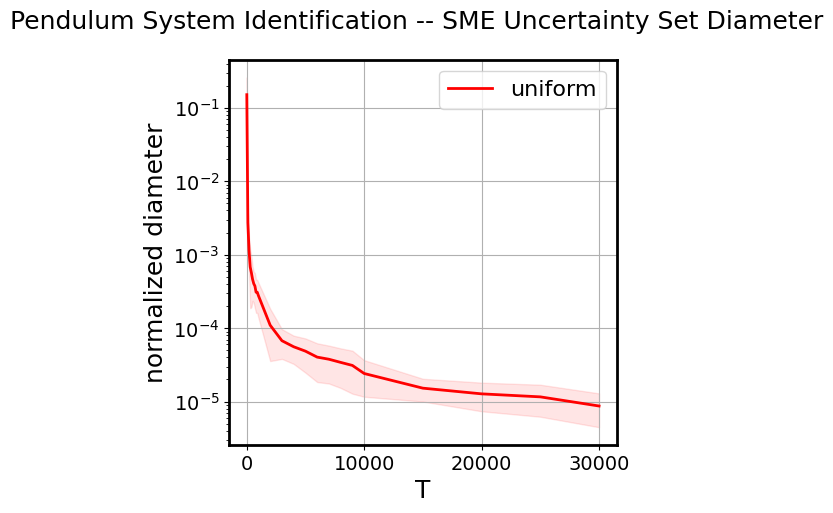

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

plt.rcParams['axes.grid'] = True

linewidth_ = 2.0
alpha_ = 0.1
log_scale = True
normalize = True
l_norm = np.inf # 2

def plot_sme_diam(mean_diam, std_diam, time_hor):

  c0 = 1
  if normalize:
    c0 = np.linalg.norm(ground_truth, l_norm)

  time_hor_ = np.array(time_hor)

  fig = plt.figure(figsize=(5, 5))
  plt.plot(time_hor, np.array(mean_diam) / c0, color='red', label=disturbance, linewidth=linewidth_)
  plt.fill_between(time_hor, (np.array(mean_diam) - np.array(std_diam)) / c0, (np.array(mean_diam) + np.array(std_diam)) / c0, color='red', alpha=alpha_)
  # plt.xticks([10, 10000, 20000, 30000])
  plt.xlabel('T')
  if normalize:
    plt.ylabel('normalized diameter')
  else:
    plt.ylabel('diameter')
  plt.legend()
  fig.suptitle('Pendulum System Identification -- SME Uncertainty Set Diameter')
  if log_scale:
    plt.yscale('log')


  plt.show()

print('------------------------SME Uncertainty Set Diameter Plot---------------------')
plot_sme_diam(mean_diam_list, std_diam_list, time_hor)

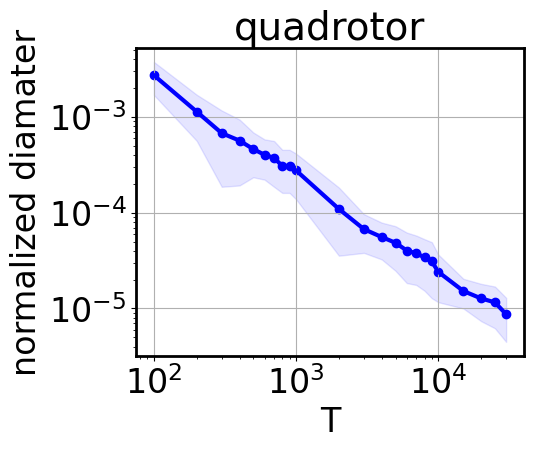

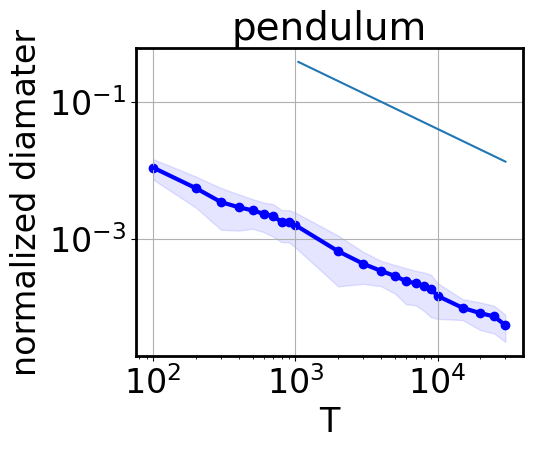

In [ ]:
from re import M
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

SMALL_SIZE = 24
MEDIUM_SIZE = 24
BIGGER_SIZE = 28

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)   # fontsize of the figure title

plt.rcParams['axes.grid'] = True
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2

normalize = True
log_scale_x = True
log_scale_y = True

if normalize:
  c_norm = np.linalg.norm(np.array(ground_truth))
else:
  c_norm = 1

time_hor = [10, 100, 200, 300, 400, 500, 600, 700, 800, 900]
time_hor.extend([1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000])
time_hor.extend([10000, 15000, 20000, 25000, 30000])


colors = ['red', 'blue']

linewidth_ = 3.0
alpha_ = 0.1


# --------------------------------------------------Uniform---------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------------------------------------
s_phi = 0.05 # estimated
p_phi = 0.8 # estimated
b_phi = 5 # estimated
w_max = 0.01

fig = plt.figure(figsize=(5, 4))

name1 = 'sme_theo_bound_1_w_uniform__0.005773502691896258_s_phi_0.005_p_phi_0.8_eps_0.1.csv'
name2 = 'sme_theo_bound_2_w_uniform__0.005773502691896258_s_phi_0.005_p_phi_0.8_eps_0.1.csv'
time_list = np.loadtxt(name1, delimiter=',')
theo_bound = np.loadtxt(name2, delimiter=',')/c_norm
label1 = 'theo'
plt.plot(time_list, theo_bound, color=colors[0], label=label1, linewidth=linewidth_)

name1 = 'sme_data1_w_uniform_[-1, 1]_[1, 1]_u_uniform_[-1, 1]_[1].csv'
name2 = 'sme_data2_w_uniform_[-1, 1]_[1, 1]_u_uniform_[-1, 1]_[1].csv'
time_list = time_hor
mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
std_theta_hat_list = np.loadtxt(name2, delimiter=',')
points = []
errors = []
for j in range(len(mean_theta_hat_list)):
  points.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
  errors.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)
label1 = 'empr'
ind = 1
plt.plot(time_list[ind:], points[ind:], color=colors[1], label=label1, linewidth=linewidth_)
plt.scatter(time_list[ind:], points[ind:], color=colors[1], marker='o')
plt.fill_between(time_list[ind:], np.array(points[ind:]) - np.array(errors[ind:]), np.array(points[ind:]) + np.array(errors[ind:]), color=colors[1], alpha=alpha_)

# plt.xlim([1000-10, 30000+10])
# plt.ylim([9e-6, 1e-2])
if log_scale_x:
  plt.xscale('log')
if log_scale_y:
  plt.yscale('log')
# plt.yticks([1e-4, 1e-3, 1e-2])

plt.xlabel('T')
if normalize:
  # plt.ylabel('$\dfrac{\|\hat{\\theta}_{T} - \\theta_{*}\|_{2}}{\|\\theta_{*}\|_{2}}$')
  plt.ylabel('normalized diamater')
else:
  plt.ylabel('diameter')

# plt.legend()
plt.title('quadrotor')
# plt.legend(ncol=1, loc=(0.5, 0.25), framealpha=0.0)

# --------------------------------------------------Truncated Gaussian---------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------------------------------------
s_phi = 0.05 # estimated
p_phi = 0.95 # estimated
b_phi = 2 # estimated
w_max = 0.01
sigma_w = 0.005

fig = plt.figure(figsize=(5, 4))

name1 = 'sme_theo_bound_1_w_trunc__0.005_s_phi_0.005_p_phi_0.7_eps_0.1.csv'
name2 = 'sme_theo_bound_2_w_trunc__0.005_s_phi_0.005_p_phi_0.7_eps_0.1.csv'
time_list = np.loadtxt(name1, delimiter=',')
theo_bound = np.loadtxt(name2, delimiter=',')/c_norm
label1 = 'theo'
plt.plot(time_list, theo_bound, color=colors[0], label=label1, linewidth=linewidth_)

name1 = 'sme_data1_w_trunc_guass_[0.0, 0.5, 2]_[1, 1]_u_trunc_guass_[0.0, 0.5, 2]_[1].csv'
name2 = 'sme_data2_w_trunc_guass_[0.0, 0.5, 2]_[1, 1]_u_trunc_guass_[0.0, 0.5, 2]_[1].csv'
time_list = time_hor
mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
std_theta_hat_list = np.loadtxt(name2, delimiter=',')
points = []
errors = []
for j in range(len(mean_theta_hat_list)):
  points.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
  errors.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)
label1 = 'empr'
ind = 1
plt.plot(time_list[ind:], points[ind:], color=colors[1], label=label1, linewidth=linewidth_)
plt.scatter(time_list[ind:], points[ind:], color=colors[1], marker='o')
plt.fill_between(time_list[ind:], np.array(points[ind:]) - np.array(errors[ind:]), np.array(points[ind:]) + np.array(errors[ind:]), color=colors[1], alpha=alpha_)

# plt.xlim([1000-10, 30000+10])
# plt.ylim([1e-3, 1e-1])
if log_scale_x:
  plt.xscale('log')
if log_scale_y:
  plt.yscale('log')
# plt.yticks([1e-4, 1e-3, 1e-2])

plt.xlabel('T')
if normalize:
  # plt.ylabel('$\dfrac{\|\hat{\\theta}_{T} - \\theta_{*}\|_{2}}{\|\\theta_{*}\|_{2}}$')
  plt.ylabel('normalized diamater')
else:
  plt.ylabel('diameter')

# plt.legend()
plt.title('pendulum')
# plt.legend(ncol=1, loc=(0.45, 0.65), framealpha=0.0)


plt.show()